In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
from sklearn.model_selection import train_test_split

##**Import pre-trained model**

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

##**Load flowers dataset**

In [39]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [4]:
data_dir
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [5]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/daisy/4413849849_b8d2f3bcf1_n.jpg'),
 PosixPath('datasets/flower_photos/daisy/2838487505_6c3b48efa5_m.jpg'),
 PosixPath('datasets/flower_photos/daisy/19544831049_0d738d4872_m.jpg'),
 PosixPath('datasets/flower_photos/daisy/483886997_27ee798327.jpg'),
 PosixPath('datasets/flower_photos/daisy/14907815010_bff495449f.jpg')]

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


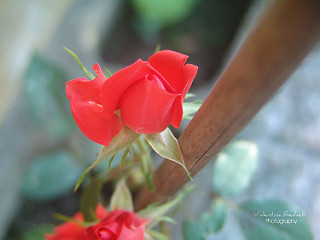

In [7]:
roses = list(data_dir.glob('roses/*'))
roses[:5]
Image.open(str(roses[1]))

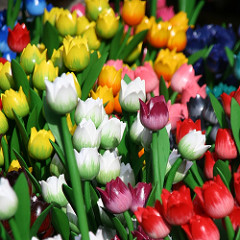

In [8]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[3]))

##**Read flowers images into numpy array using opencv**

In [9]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [10]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}
class_names = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [11]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/12406418663_af20dc225f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5863698305_04a4277401_n.jpg'),
 PosixPath('datasets/flower_photos/roses/2448812029_047d981092_m.jpg'),
 PosixPath('datasets/flower_photos/roses/4921988677_e2eb0c9a24_m.jpg'),
 PosixPath('datasets/flower_photos/roses/3171577977_8608282f04_m.jpg')]

In [12]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/12406418663_af20dc225f_n.jpg'

In [13]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(231, 320, 3)

In [14]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

##**Resize all the image for the model**

In [15]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [16]:
X = np.array(X)
y = np.array(y)

##**Train Test split**

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=0)

##**Preprocessing**

In [18]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [19]:
X[0].shape

(224, 224, 3)

##**Take pre-trained model and retrain it using flowers images**

In [20]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [21]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [23]:
h = model.fit(X_train_scaled, Y_train, epochs=5, validation_split=0.2)

Epoch 1/5
69/69 [==============================] - 9s 67ms/step - loss: 0.8575 - accuracy: 0.6761 - val_loss: 0.5977 - val_accuracy: 0.7804
Epoch 2/5
69/69 [==============================] - 3s 50ms/step - loss: 0.4335 - accuracy: 0.8437 - val_loss: 0.4799 - val_accuracy: 0.8221
Epoch 3/5
69/69 [==============================] - 3s 50ms/step - loss: 0.3241 - accuracy: 0.8928 - val_loss: 0.4442 - val_accuracy: 0.8439
Epoch 4/5
69/69 [==============================] - 3s 50ms/step - loss: 0.2641 - accuracy: 0.9205 - val_loss: 0.4424 - val_accuracy: 0.8439
Epoch 5/5
69/69 [==============================] - 3s 50ms/step - loss: 0.2275 - accuracy: 0.9373 - val_loss: 0.4191 - val_accuracy: 0.8621


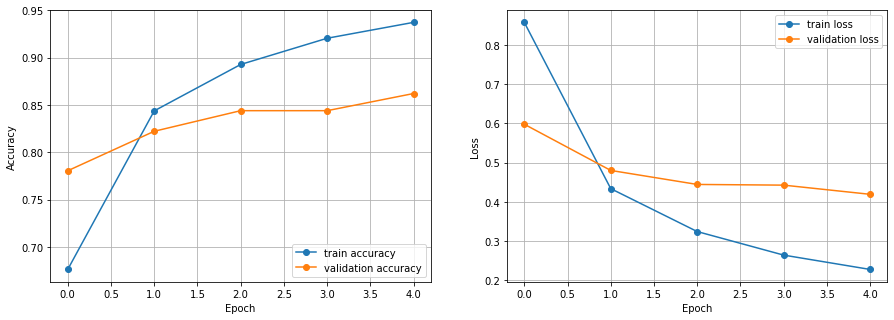

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [25]:
test_loss, test_acc = model.evaluate(X_test_scaled,Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

29/29 [==============================] - 2s 54ms/step - loss: 0.3993 - accuracy: 0.8660

Test Accuracy: 0.8660130500793457

Test Loss: 0.39931896328926086


In [26]:
predictions = model.predict(X_test)

In [27]:
predictions[0]

array([-2.5852797 ,  0.3972585 ,  0.21129769, -2.8864596 , -1.8809102 ],
      dtype=float32)

In [28]:
np.argmax(predictions[0])

1

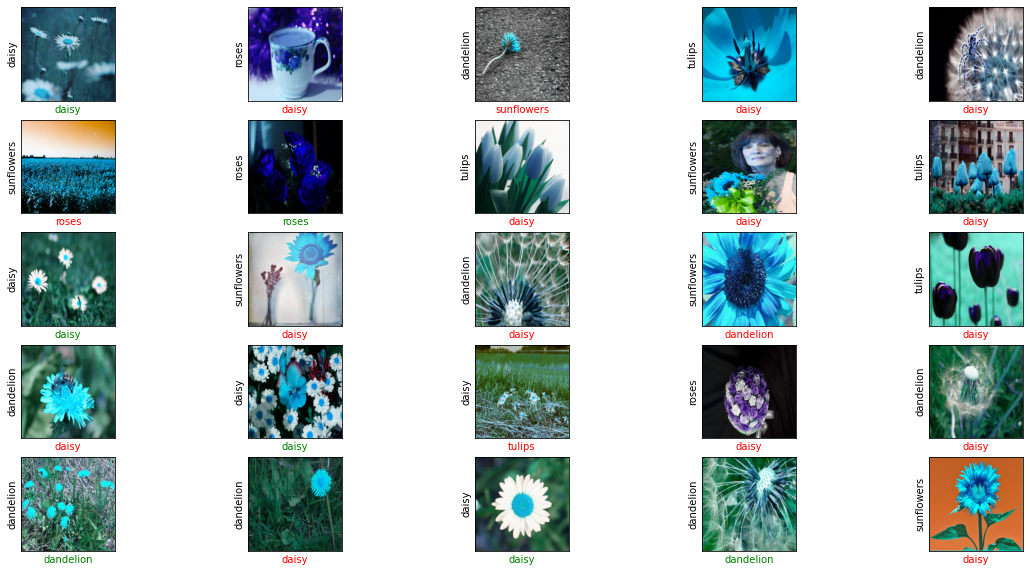

In [38]:
rows = 5
cols = 5

plt.figure(figsize=(20,10))
for i in range(25):
    
    plt.subplot(rows, 2*cols, 2*i+1)
    plt.imshow(X_test[i])
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(class_names[Y_test[i]])
    if Y_test[i] == np.argmax(predictions[i]):
        plt.xlabel(class_names[np.argmax(predictions[i])], color='g')
    else:
        plt.xlabel(class_names[np.argmax(predictions[i])], color='r')
    
plt.show()